# Secondary structure prediction, influence of protein family and using evolutionary information

### By Yelda Büyük, Master Computer Science, 0527366, Vrije Universiteit Brussel, 2019-2020

The goal of this assignment is to develop an insight to the given data and concepts behind secondary structure prediction. This notebook contains the GOR III implementation alongside the documentation that is necessary to achieve this goal. 

The first part contains the parsing and the mapping of the data. The second part contains some auxiliary functions that are used during the development phase of the algorithm. The third part is dedicated to the algorithm itself and it split up into two parts: 1) the training phase and 2) the prediction phase. The next part part includes the computation of the Q3, MCC and the protein family predictions. The final part discusses the evaluation of the obtained results.

## Part I: Parsing and mapping the data

We receive two datasets: dssp_info.txt and stride_info.txt. These files can be found in the data folder. These files contain the following information per column: the protein code, the protein chain code, the protein sequence code, the residue name and the secondary structure. 

Parsing is the first step of this project as data is required to compute results. To ease the process, we decide to work with one letter codes instead of the provided three letter codes and thus map these.

In [1]:
import numpy as np
import csv

# Defining the datasets.
dssp = 'data/dssp_info.txt'
stride = 'data/stride_info.txt'

# Parsing the datasets. One can switch between datasets by replacing dssp or stride by the other.
use_dataset = np.loadtxt(dssp, dtype=np.str, delimiter='\t')

# Defining two dictionaries for the mapping of the data. The files contain three letter codes, which is not
# evident. The mapping information is taken from the following link: https://nl.wikipedia.org/wiki/Aminozuur
amino_acid_dic = {'ALA': 'A', 'ARG': 'R', 'ASN': 'N', 'ASP': 'D', 'CYS': 'C', 'PHE': 'F', 'GLN': 'Q', 'GLU': 'E', 'GLY': 'G', 'HIS': 'H', 'ILE': 'I', 'LEU': 'L', 'LYS': 'K', 'MET': 'M', 'PRO': 'P', 'SER': 'S', 'THR': 'T', 'TRP': 'W', 'TYR': 'Y', 'VAL': 'V'}
# We notice irregular states within the dataset. We decide to map the odd states as Coil. 
state_codes_dic = {'Helix': 'H', 'Beta': 'E', 'Coil': 'C', 'Other': 'C'}

# Higher order function to map a given three letter code with a given dictionary to the corresponding one letter 
# code. Every not standard defined amino acid will be mapped as an X.
def map_single_code(three_letter_code, dictionary):
    if three_letter_code not in dictionary:
        return 'X'
    else:
        return dictionary[three_letter_code]

# Function to map all the required codes within the dataset. It returns an array of four elements: 
# the training amino acid sequence, the training secondary sequence (the actual secondary sequence), 
# the protein amino acid sequence and the protein secondary sequence.
def map_all_codes(protein, dataset):
    training_acid_seq = ''
    training_secondary_seq = ''
    protein_acid_seq = ''
    protein_secondary_seq = ''
    # Fetching the individual data from the columns.
    for row in dataset:
        protein_code = row[0]
        amino_code = row[3]
        state_code = row[4]
        # Leaving one out. Protein to be predicted is left out of the training set.
        if protein_code != protein:
            # Map the codes and add it to the correct string.
            training_acid_seq += map_single_code(amino_code, amino_acid_dic)
            training_secondary_seq += map_single_code(state_code, state_codes_dic)
        else:
            protein_acid_seq += map_single_code(amino_code, amino_acid_dic)
            protein_secondary_seq += map_single_code(state_code, state_codes_dic)
    return [training_acid_seq, training_secondary_seq, protein_acid_seq, protein_secondary_seq]

## Part II: Auxiliary functions

The second part consits out of auxiliary fuctions that were required to make during the development of the algorithm. By using higher order functions it cleans up the code and makes it easier to read/find bugs. The description of each function is written in the cell below.

In [2]:
# Given a specific key (can either be an amino acid or a state), increment the correct information in the
# corresponding dictionary. If the key is not in the dictionary, add it with intial value 1 because at 
# that moment we are coming across the key. If it already is a member of the dictionary, increment with 1. 
def count_type(key, dic):
    if key not in dic:
        dic.update({key: 1})
    else:
        dic[key] += 1
    return dic

# Given a specific state, this function returns the index of that state.
def fetch_state_index(state):
    states = ["H", "E", "C"]
    return states.index(state)

# Given a specific index, this function returns the state corresponding to the index.
def fetch_state(idx):
    states = ["H", "E", "C"]
    return states[idx]

# Function to fetch the index of a value within an array. 
# Returns the index of a value. 
def fetch_index(array, value):
    if value in array:
        return array.index(value)

# There is a need to increment the other states except the current one. We do this to update the "not" columns.
# Takes the current state, increment the others and returns the result.
def fetch_opposite_idxs(curr_state):
    opposite_states = ({"H": [1, 2], "E": [0, 2], "C": [0, 1]})
    return opposite_states[curr_state]

# Function to count the amino's with a specific state into a dictionary.
# Takes an amino acid, its corresponding state and the dictionary to store the result in.
def count_per_amino(amino, state, dic):
    if amino not in dic:
        dic.update({amino: [[0,0], [0,0], [0,0]]}) 
    state_idx = fetch_state_index(state)
    dic[amino][state_idx][0] += 1
    return dic

    
# Function to add the "not" states per key given a dictionary.
# It uses the total amount of amino acids per type. This forms a subset of that amino acid.
# Returns the amino acid dictionary with its updated information.-
def add_non(dic, dic_subset, pos_column, neg_column):
    for key in dic:
        value = dic[key]
        total_value = dic_subset[key]
        for i in range(3): 
            if total_value != 1:
                if total_value != dic[key][i][neg_column]:
                    dic[key][i][pos_column] = total_value - value[i][neg_column] 
                else:
                    dic[key][i][pos_column] = (total_value + 1) - value[i][neg_column]
    return dic

# For a given key and an array of dictionaries, initialize the value of the key within the dictionary.
# Returns the dictionary of arrays for further use.
def update_dictionaries_empty(key, array_of_dic):
    for i in range(len(array_of_dic)):
        if key not in array_of_dic[i]:
            array_of_dic[i].update({key: [0,0,0]})
    return array_of_dic

# Given position i and j, return the relative position of i from j.
def get_rela_pos(i, j): 
    pair_pos = i - j
    if pair_pos < 0:
        return str(pair_pos)
    else:
        return ('+' + str(pair_pos))

# Given an amino sequence, the position of amino_j and the location of its pair, form a three dimensional key
# and return it.
def get_pair_key(amino_seq, i, j):
    amino_j = amino_seq[j]
    amino2 = amino_seq[i]
    rela_pos = get_rela_pos(i,j)
    return (amino_j + rela_pos + amino2)

# Given an amino at position j and the dictionary with the information for the prediction, return the 
# predicted state for that amino acid.
def predict_state(amino_j, predict_dic):
    max_value = max(predict_dic[amino_j])
    index_value = fetch_index(predict_dic[amino_j], max_value)
    return fetch_state(index_value)

def get_info(denom1, denom2, num1, num2):
    if (denom1 != 0) and (denom2 != 0):
        return np.log(num1/denom1) + np.log(num2/denom2)
    elif (denom1 != 0) and (denom2 == 0):
        return np.log(num1/denom1)
    elif (denom1 == 0) and (denom2 != 0):
        return np.log(num2/denom2)
    else:
        return 0

# Part III: The algorithm - GOR III
The algorithm, GOR III, consists out of two parts: the training phase and the prediction phase. The goal of implementing the algorithm is to be able to predict a secondary structure sequence for a given protein with a theoretical accuracy of ~ 63%.

The algorithm takes a protein name and its dataset in. It uses the leave-one-out method to exclude the to-be-evaluated protein out of the trainings phase. The algorithm needs to be retrained for every protein input. When the training is over, we switch over to the prediction phase. During the prediction phase, the algorithm will have the information available from the training phase. During the training phase the program will have counted the required information and stored these in dictionaries that are then passed on to the prediction phase. The prediction phase is where the real calculation comes into play. Once a prediction is formed, the prediction string of the secondary structure is formed and returned with the actual secondary structure of the protein. These two will be used in future calculations.

## The training phase
During the training phase two things happen: the information for the self information and for the pair information gets obtained. 

The self information starts with counting the amino acids at position j with its current state and the opposite of that. The information gets stored in an amino acid dictionary. The next step is to count the states that are used in the actual secondary sequence of the protein and compare it with the overall states. Once this information is obtained, the self information is calculated with the following formula:

$$I(\Delta S_{j};R_{j}) = log(f_{S_{j}, R_{j}}/f_{n-S_{j}, R_{j}}) + log(f_{n-S}/f_{S})$$

### Self information

In [3]:
# This function calculates the self information per amino acid for each state. It takes the dictionary
# with the amino acids at position j with a specific state; its opposite, the dictionary with the states count from the
# entire secondary sequence, and the dictionary with the opposite information. 
# For each amino acid in the amino dictionary we will be calculating the self information. The result
# gets stored in the result dictionary. This dictionary is returned.
def calculate_res_self_info(amino_dic, states_dic, not_states):
    res_dic = {}
    for key in amino_dic:
        value = amino_dic[key]
        # We use range 3 because we have 3 states.
        for i in range(3):
            fSR = value[i][0]
            fNSR = value[i][1]
            state = fetch_state(i)
            fNS = not_states[state]
            fS = states_dic[state]
            if key not in res_dic:
                res_dic.update({key: [0,0,0]})            
            res_dic[key][i] = get_info(fNSR, fS, fSR, fNS)
    return res_dic

# Function to train the self information. We have mentioned that we only count during the trainig phase 
# and calculte during the prediction phase, but as we have enough information we decided to calculate the
# self information during the training phase already.
# During the training first the counts happen, then by calling the calculate_res_self_info we calculate
# the self information. The result is an amino acid at position j with each state and for each state
# the dictionary contains the self information.
def train_self_info(amino_seq, secondary_seq):
    amino_dic = {}
    subset_dic = {}
    states_dic = {}
    not_states = {}
    for j in range(len(amino_seq)):
        amino_j = amino_seq[j]
        state = secondary_seq[j]
        # Count amino acids at position j with its state.
        amino_dic = count_per_amino(amino_j, state, amino_dic)
        # Count subsets per amino
        subset_dic = count_type(amino_j, subset_dic)
        # Count states
        states_dic = count_type(state, states_dic)
    # Add non states of amino_j with a state.
    amino_dic = add_non(amino_dic, subset_dic, 1, 0)
    # Add non states.
    total_states = 0
    for state in states_dic:
        total_states += states_dic[state]
    for state in states_dic:
        if state not in not_states:
            not_states.update({state: 0})
        not_states[state] = total_states - states_dic[state]
        
    # Calculate self info.
    return calculate_res_self_info(amino_dic, states_dic, not_states)

The next step is to calculate the pair information. We begin by counting the information. For every amino acid in the amino acid sequence, we open up a window of 16 big. In the beginning this window will be smaller. This means that for example at position 0 the window will go from 0 to 8, at position 8 the window will go from position 0 to 16. This iterates over the entire sequence.

Per window we have the amino acid at position j. We start iterating over the window and per iteration, we generate a pair with the amino acid at position j and the amino acid at the iteration i. For every pair, except where amino acid j would be paired with itself (we leave this one out), we increment the count for it. We do this by making a three dimensional key which contains the amino acid at position j letter, the relative position of the amino acid at position i (for example if the amino acid is at relative position -8 then this part would say -8) and the amino acid letter at position i. This three dimensional information key is then stored into a dictionary. Everytime we come across this specific informatoin we increment the correct value. We do this for the entire amino acid sequence. We follow the following formula for this part:

$$I(\Delta S_{j};R_{j+m}|R_{j}) = log(f_{S_{j}, R_{j+m}, R_{j}}/f_{n-S_{j}, R_{j+m}, R_{j}}) + log(f_{n-S_{j}, R_{j}} / f_{S_{j}, R_{j}})$$

### Pair information

In [4]:
# This function, given a begin and en end, counts the pairs per window. It forms the necessary key
# and increments the count.
# Returns the pair dictionary with its counts, and the opposite information.
# Per pair we have three states, every state has the same key for the same pair. This information
# is kept in a dictionary. The value being an array with three slots, one for each state.
def count_pair_info_window(range_begin, range_end, j, state_idx, amino_seq, pair_dic, not_states_arr, not_pair_dic):
    for i in range(range_begin, range_end):
        # Can not have the pair where the two amino acids are equal.
        if j != i:
        # Form a key.
            pair_key = get_pair_key(amino_seq, i, j)
            rela_pos = get_rela_pos(i,j)
            arr_dics = update_dictionaries_empty(pair_key, [pair_dic, not_pair_dic])
            pair_dic = arr_dics[0]
            not_pair_dic = arr_dics[1]
            # Increment count.
            pair_dic[pair_key][state_idx] += 1
            # Increment the not states.
            for not_state_idx in not_states_arr:
                not_pair_dic[pair_key][not_state_idx] += 1
    return [pair_dic, not_pair_dic]

#This function is where we iterate over the entire amino acid sequence and increment the correct keys. Per 
# amino acid we look at the window and count the pairs per window. The sequence is split up into four parts,
# the first two make up the begin part, the third part forms the middle part and the last part forms
# the ending of the sequence. Once the count is done for the pairs, we count the amino acid at position
# j with its state. That is the second part of this function.
# Returns three dictionaries.
def count_pair_info(amino_seq, secondary_seq):
    pair_dic = {}
    not_pair_dic = {}
    subset_dic = {}
    amino_dic = {}
    for j in range(len(amino_seq)):
        amino_j = amino_seq[j]
        state_j = secondary_seq[j]
        # Fetch state index.
        state_idx = fetch_state_index(state_j)
        # Fetch the indexes of the not states to be incremented.
        not_states_arr = fetch_opposite_idxs(state_j)
        score_amino_j = 0
        # Calculate the information per window. Add result to the result dictionary.
        # When we come across the same amino acid, we repeat this process. If a specific state has higher value
        # than the one noted in the dictionary, we replace it.
        
        # Window from 0 to 7.
        if j == 0:
            range_begin = 0
            range_end = 8
            res = count_pair_info_window(range_begin, range_end, j, state_idx, amino_seq, pair_dic, not_states_arr, not_pair_dic)
            pair_dic = res[0]
            not_pair_dic = res[1]
        elif j <= 8:
            range_begin = 0
            range_end = j + 8
            res = count_pair_info_window(range_begin, range_end, j, state_idx, amino_seq, pair_dic, not_states_arr, not_pair_dic)
            pair_dic = res[0]
            not_pair_dic = res[1]
        elif (j > 8) and (j < ((len(amino_seq) - 8))):  # For the pairs between this interval.
            range_begin = j - 8
            range_end = j + 8
            res = count_pair_info_window(range_begin, range_end, j, state_idx, amino_seq, pair_dic, not_states_arr, not_pair_dic)
            pair_dic = res[0]
            not_pair_dic = res[1]
        else: # last part
            range_begin = j - 8
            range_end = len(amino_seq)
            res = count_pair_info_window(range_begin, range_end, j, state_idx, amino_seq, pair_dic, not_states_arr, not_pair_dic)
            pair_dic = res[0]
            not_pair_dic = res[1]
    
    ## Now calculate subset information.
    # Iterate over sequence.
    # For every amino acid, keep track how many times they are present -- generating subsets per amino acid.
    for i in range((len(amino_seq))):
        amino = amino_seq[i]
        state = secondary_seq[i]
        # Count the subsets per amino acid.
        subset_dic = count_type(amino, subset_dic)
        # For every amino acid we encounter, check its state and increment the corresponding position in the 
        # dictionary.
        amino_dic = count_per_amino(amino, state, amino_dic)
        # Add non states per amino.
        amino_dic = add_non(amino_dic, subset_dic, 1, 0) # not is column two
        
    return [pair_dic, not_pair_dic, amino_dic]

## The prediction phase

This phase predicts a secondary structure sequence for a given protein. By using the information that we have acquired during the trainings phase, we can now generate a state prediction per amino acid in the amino acid sequence by using the gor3 formula, this is where we add the self information with the pair information per window and select the state with the highest self information per amino acid.

$$ I(\Delta S_{j};R_{1},...,R_{n}) \approx I(\Delta S_{j};R_{j}) + \sum_{m=-8, m\neq 0}^{m=8} I(\Delta S_{j};R_{j+m}|R_{j})$$

In [5]:
# Function to calculate the result per pair. This function will be needed to calculate the information
# for the three states per pair within a window.
# It takes a pair as a key, the dictionary with the pair information, the dictionary with the not pair 
# information, the dictionary with the amino's and the not amino's state, and the dictionary with the
# final sum per pair within a window. This is needed to predict the state.
# If the key is not in the pair dictionary, we do not have information from the training set for this
# pair of amino acids at a relative position and are forced to use the dummy data of an array of 0's.
# Returns the dictionary with the updated pair sum within a window.
def calculate_result_per_pair(amino_seq, i, j, pair_dic, not_pair_dic, amino_dic, pair_sum_dic):
    # In the event that the dictionary contains the value for the given key.
    key = get_pair_key(amino_seq, i, j)
    amino_j = key[:1]
    if key in pair_dic:
        pair_value = pair_dic[key]
        not_pair_value = not_pair_dic[key]
        amino_value = amino_dic[amino_j]
        # Per state
        for i in range(3):
            # Pair's
            fSRR = pair_value[i]
            fNSRR = not_pair_value[i]
            # Amino's
            fSR = amino_value[i][0]
            fNSR = amino_value[i][1]
            # Calculate the information.
            if amino_j not in pair_sum_dic:
                pair_sum_dic.update({amino_j: [0,0,0]})
            # Calculate and add the information to the dictionary.
            pair_sum_dic[amino_j][i] += get_info(fNSRR, fSR, fSRR, fNSR)
    else:
        if amino_j not in pair_sum_dic:
            pair_sum_dic.update({amino_j: [0,0,0]})
    return pair_sum_dic

# Function to calculate a state per amino acid. 
# Returns the prediction.
def predict_per_amino(range_begin, range_end, j , protein_seq, pair_dic, self_dic, not_pair_dic, amino_dic, pair_sum_dic, predict_dic):
    amino_j = protein_seq[j]
    for i in range(range_begin, range_end):
        if i != j:
            # Calculate information per pair for every state.
            # Dictionary to keep track of results.
            sum_pair_dic = calculate_result_per_pair(protein_seq, i, j, pair_dic, not_pair_dic, amino_dic, pair_sum_dic)
    # For every state, calculate the prediction information for amino acid at position j.
    for i in range(3):
        info = pair_sum_dic[amino_j][i] + self_dic[amino_j][i]
        predict_dic[amino_j][i] += info
    # Finally, predict the state for the amino acid at position j.
    return predict_state(amino_j, predict_dic)

# Function to generate prediction. It iterates over the entire amino acid sequence. Per amino acid at position
# j, we look to the window that goes from j - 8 to j + 8 and calculate the self information for each of the
# three states with the information that we acquired during the trainings phase.
# The state with the highest self information is chosen as prediction and is appended to the final prediction
# sequence.
# The formula that is used to calculate the prediction is given above this cell. 
# Returns the prediction for the secondary sequence.
def generate_prediction(amino_dic, pair_dic, not_pair_dic, self_dic, protein_seq):
    prediction = ''
    for j in range((len(protein_seq))):
        amino_j = protein_seq[j]
        pair_sum_dic = {}
        predict_dic = {}
        array_dics = update_dictionaries_empty(amino_j, [predict_dic, self_dic])
        predict_dic = array_dics[0]
        self_dic = array_dics[1]
        if j == 0:
            range_begin = 0
            range_end = 8
            prediction += predict_per_amino(range_begin, range_end, j, protein_seq, pair_dic, self_dic, not_pair_dic, amino_dic, pair_sum_dic, predict_dic)
        elif j <= 8:
            range_begin = 0
            range_end = j + 8
            prediction += predict_per_amino(range_begin, range_end, j, protein_seq, pair_dic, self_dic, not_pair_dic, amino_dic, pair_sum_dic, predict_dic)
        elif (j > 8) and (j < ((len(protein_seq) - 8))):
            range_begin = j - 8
            range_end = j + 8
            prediction += predict_per_amino(range_begin, range_end, j, protein_seq, pair_dic, self_dic, not_pair_dic, amino_dic, pair_sum_dic, predict_dic)
        else: # length j >= length of protein_seq - 8
            range_begin = j - 8
            range_end = len(protein_seq)
            prediction += predict_per_amino(range_begin, range_end, j, protein_seq, pair_dic, self_dic, not_pair_dic, amino_dic, pair_sum_dic, predict_dic)
    return prediction

## Forming the algorithm
This is the main part where the algorithm is formed. We define the gor3 function. It takes a protein and a dataset. We start out by mapping the necessary information with our map_all_codes function. We obtain four sequences from this: the amino acid sequence necessary for the training as well as the actual secondary structure sequence as well as the protein amino acid sequence and the protein secondary structure sequence. Afterwards the training phase is called, where we train the algorithm and leave the protein that needs to be evaluated out of this phase. The trainig phase delivers different dictionaries which are then in turns used to predict the secondary structure sequence for the give protein. The algorithm returns the actual secondary structure sequence and the predicted secondary structure sequence. 

In [6]:
# Creating the GOR III algorithm. It takes a protein code as parameter and returns the prediction. 
def gor3(protein, dataset):
    # Mapping the required three letter codes to a one letter based string. Returns the amino acid sequence
    # and the actual seconary structure for the training phase.
    codes = map_all_codes(protein, dataset)
    # Fetching the training sequences and the protein sequences. These will be needed to generate a prediction.
    train_acid_sequence = codes[0]
    train_secondary_structure = codes[1]
    protein_acid_sequence = codes[2]
    protein_secondary_structure = codes[3]
    # Training phase
    # Counting and calculating the self information.
    result_self_dic = train_self_info(train_acid_sequence, train_secondary_structure)
    # Counting pair information.
    result_pair_dic_arr = count_pair_info(train_acid_sequence, train_secondary_structure)
    pair_dic = result_pair_dic_arr[0]
    not_pair_dic = result_pair_dic_arr[1]
    amino_dic = result_pair_dic_arr[2]
    # Generating prediction for the given protein and the dataset.
    prediction = generate_prediction(amino_dic, pair_dic, not_pair_dic, result_self_dic, protein_acid_sequence)
    return [prediction, protein_secondary_structure]

# Part IV: Q3

The Q3 measure gives you information on the accuracy of a predicted secondary structure sequence. We compare the prediction with its actual secondary structure sequence. It calculates how many states are correctly predicted and generates the accuracy percentage. However, this does not tell you how accurate every state has been predicted. For this information we must take a look at the MCC score for each secondary state.

$$ Q_{3} = N_{residues\_correctly\_predicted} / N_{residues\_total} $$

In [7]:
# Function to calculate the Q3 score of the secondary predicted structure of a protein.
# The predicted secondary structure gets compared with the actual secondary structure that we parse during
# GOR III. For every residue in the prediction sequence, we check if it matches with the actual one.
# Returns the correctly predicted percentage.
def calculate_q3(gor3_result):
    prediction = gor3_result[0]
    protein_sec = gor3_result[1]
    total_residues = 0
    correct_predicted_residues = 0
    for residue in range(len(prediction)):
        actual_ss_residue = protein_sec[residue]
        predicted_residue = prediction[residue]
        if actual_ss_residue == predicted_residue:
            correct_predicted_residues += 1
        total_residues += 1
    return correct_predicted_residues/total_residues

# Part V: MCC 

The MCC score tells us how accurate we have predicted each type of state. For every state we calculate the MCC score with the following formula:

 $$ MCC = TP \times TN - FP \times FN / \sqrt{(TP + FP)(TP + FN)(TN + FP)(TN + FN)} $$

with TP being the true positives, TN the true negatives, FP the false positives and FN the false negatives.
A true positive means that both states are of the same type. A false positive means that for example, the prediction state is the given state (a helix for example) and the actual residue being something else. A false negative means that the actual residue is the given state and the predicted residue is something else. A true negative means that both the actual residue and the predicted residue are not the given state.

In [8]:
def calc_mcc(gor3_result):
    predicted_struc = gor3_result[0]
    actual_second_struc = gor3_result[1]
    mcc_counts = {}
    mcc_result = {}
    TP_idx = 0
    FP_idx = 1
    FN_idx = 2
    TN_idx = 3
    #for every staste
    for state_idx in range(3):
        # Fetch state
        state = fetch_state(state_idx)
        if state not in mcc_counts:
            mcc_counts.update({state: [0,0,0,0]}) # TP, FP, FN, TN
        # Compare each predicted residue with the actual residue. Increment the correct count.
        for i in range((len(actual_second_struc))):
            actual_residue = actual_second_struc[i]
            predicted_residue = predicted_struc[i]
            # Compare and increment.
            if (actual_residue == state) and (predicted_residue == state):
                mcc_counts[state][TP_idx] += 1
            elif (actual_residue == state) and (predicted_residue != state):
                mcc_counts[state][FN_idx] += 1
            elif (actual_residue != state) and (predicted_residue == state):
                mcc_counts[state][FP_idx] += 1
            else:
                mcc_counts[state][TN_idx] += 1
            # Use formula.
            #check for 0's and add 1
            if(mcc_counts[state][TP_idx] == 0) and (mcc_counts[state][FP_idx] == 0):
                mcc_counts[state][TP_idx] += 1
            if(mcc_counts[state][TP_idx] == 0) and (mcc_counts[state][FN_idx] == 0):
                mcc_counts[state][TP_idx] += 1
            if(mcc_counts[state][TN_idx] == 0) and (mcc_counts[state][FP_idx] == 0):
                mcc_counts[state][TN_idx] += 1
            if(mcc_counts[state][TN_idx] == 0) and (mcc_counts[state][FN_idx] == 0):
                mcc_counts[state][TN_idx] += 1
            
        num = ((mcc_counts[state][TP_idx] * mcc_counts[state][TN_idx]) - (mcc_counts[state][FP_idx] * mcc_counts[state][FN_idx]))
        denom = np.sqrt((mcc_counts[state][TP_idx] + mcc_counts[state][FP_idx]) * (mcc_counts[state][TP_idx] + mcc_counts[state][FN_idx]) * (mcc_counts[state][TN_idx] + mcc_counts[state][FP_idx]) * (mcc_counts[state][TN_idx] + mcc_counts[state][FN_idx]))
        result_per_state = num / denom
        if state not in mcc_result:
            mcc_result.update({state: 0}) # Helix, Sheet, Coil
        mcc_result[state] = result_per_state
    return mcc_result
    
    

# VI: Predicting a protein family
Another piece of information that we must predict for each protein is the protein family that it belongs to.
Give a protein, its prediction and the dataset, we try to predict its protein family. This happens in multiple steps. First we parse the CATH file, which contains the protein families of each protein. We save this information in a dictionary. The second part is to get all of the secondary structure sequences for all of the proteins within a dataset except for the protein to be evaluated. We save these in the all_second_structs dictionary. The next step is to look per item in the all_second_structs dictionary and calculate the amount of times each secondary state appears in the secondary structure sequence. We do this for each state and generate a percentage out of 100 (100 being the entire length of the sequence). Afterwards we do the same thing for the prediction itself. The next step is to sort every state % information into 3 new arrays. These arrays are part of "percentages". The first array will be the array with every helix information for every protein, the second for the sheet information and the last being the coil. After we have filled these arrays, we map these arrays so that we create new arrays which contain the difference between each value and the value of the state of the prediction. When we take the minimum value of this array, we have the closest value to the prediction %. By using this nearest %, we obtain 3 nearest protein families, 1 for each state. We apply the majority rule and choose the protein family with the maximum value. If these values are equal, it will be the first value.

In [9]:
def predict_class(protein, prediction, dataset):
    training_set= np.loadtxt('data/cath_info.txt', dtype=np.str, delimiter='\t')
    actual_class = {} # dictionary to store protein - class values.
    all_second_structs = {}
    percentages = [[],[],[]]
    protein_names = []
    # Parse CATH file and save into dictionary.
    for row in training_set:
        protein_name = row[0]
        protein_class = row[2]
        # leave self out
        if protein_name != protein:
            actual_class.update({protein_name: protein_class})
    #Parse the secondary structure sequences of all the proteins except the one being evaluated.
    for row in dataset:
        protein_name = row[0]
        second_struc = map_single_code(row[4], state_codes_dic)
        if protein_name not in all_second_structs:
            all_second_structs.update({protein_name: ''})
        #append
        all_second_structs[protein_name] += second_struc
    # Calculate % of H, E and C in a secondary structure sequence.
    for row in all_second_structs:
        protein_names.append(row)
        count_dic = {}
        second = all_second_structs[row]
        for i in range(len(second)):
            if second[i] not in count_dic:
                count_dic.update({second[i] : 0})
            count_dic[second[i]] += 1
        for struct in count_dic:
            count_dic[struct] = count_dic[struct] / len(second)
        for struct in count_dic:
            index = fetch_state_index(struct)
            arr = percentages[index]
            arr.append(count_dic[struct])
    # Calculate % of H, E, C in own prediction
    count_dic = {}
    for struct in prediction:
        if struct not in count_dic:
            count_dic.update({struct: 0})
        count_dic[struct] += 1
    for struct in count_dic:
        count_dic[struct] = count_dic[struct]/len(prediction)
    # Map each state value to a new dictionary, map them to new arrays, select minimum value and 
    # fetch the three closests protein families. Apply the majority rule to predict a protein family.
    pred_protein = {}
    for i in range(len(percentages)):
        curr_arr = percentages[i]
        state = fetch_state(i)
        if state in count_dic:
            value = count_dic[state]
            abs_arr = list(map(lambda x : abs(value - x) if x > 0 else (value + abs(x)), curr_arr))
            nearest = np.amin(abs_arr)
            protein_n = protein_names[abs_arr.index(nearest)]
            if protein_n in actual_class:
                class_n = actual_class[protein_n]
            else:
                class_n = "None"
            if class_n not in pred_protein:
                pred_protein.update({class_n: 0})
            pred_protein[class_n] += 1
    
    return max(pred_protein)

# Part VII: Calculating for all proteins

This is where we calculate everything for all the proteins for a given dataset. The results gets written to an output file. 

In [10]:
# Calculate all of the information for an entire dataset.
def calculate_for_all(dataset, filename):
    list = {}
    gor_aantal = 0
    for row in dataset:
        if row[0] not in list:
            list.update({row[0]: 0})
    with open((filename + "_output.csv"),mode='w') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(["filename", "protein", "prediction", "Q3", "MCC_Helix", "MCC_Sheet", "MCC_Coil", "Class prediction"])
        for protein in list:
            gor3_res = gor3(protein, dataset)
            q3_res = calculate_q3(gor3_res)
            gor_aantal +=  1
            list[protein] = q3_res
            mcc_res = calc_mcc(gor3_res)
            class_prediction = predict_class(protein, gor3_res[0], dataset)
            #write result
            writer.writerow([filename, protein, gor3_res[0], q3_res, mcc_res["H"], mcc_res["E"], mcc_res["C"], class_prediction])

# Initiating calculations...
# Chance dssp to stride if you wish to write to a stride output file. Do not forget to change the use_dataset
# variable to the stride dataset in te beginning of this self sustained notebook.
# Uncomment the next line if you wish to compute output files.
# calculate_for_all(use_dataset, "dssp")
print("Done.")

Done.


# Part VIII: Evaluation
At this point in the notebook we have generated all the necessary output files to discuss the results. We will be comparing the results for the Q3 values, the thee MCC values for the two datasets, DSSP and STRIDE. Afterwards we will evaluate these scores per protein family.

In [11]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

# Function to generate an array with information to be used to plot data.
def get_array_csv(csvfile, col):
    arr = []
    with open(csvfile) as csv_file:
        read = csv.reader(csv_file, delimiter = ',')
        next(read)
        for row in read:
            arr.append(float(row[col]))
    return sorted(arr)

# Function to compare a given value for two given datasets.
# Plot the graph.
def compare_2_values(output1, output2, col,label1, label2, title):
    arr1 = get_array_csv(output1, col)
    arr2 = get_array_csv(output2,col)
    fig, ax = plt.subplots(figsize=(10,8))
    ax.plot(arr1, label=label1)
    ax.plot(arr2, label=label2)
    ax.set_title(title) # set a title
    ax.legend() # show a legend on the plot

## Q3 values: STRIDE and DSSP

As mentioned earlier, the Q3 value calculates the accuracy of a secondary structure sequence prediction. It compares every predicted state with the actual state. Figure 1 shows the Q3 values for the STRIDE and the DSSP datasets. We notice that Q3 values for both the datasets are about the same, except that the STRIDE dataset produces slightly higher Q3 values as the dataset progresses. In the beginning the opposite was true. Both datasets contain 494 proteins and both datasets have an average Q3 value of 60% (this can be calculated by adding up all of the Q3 values and dividing it by the total amount of proteins). This can be aso seen by looking at the graph, we notice that most of the data points steady around 60%, meaning that there are a lot of data points who have a Q3 value near this value. The reason that these Q3 values are almost exactly the same (they differ when you expand the decimals), is that we have chosen in the beginning to map all of the Other data to Coil. 

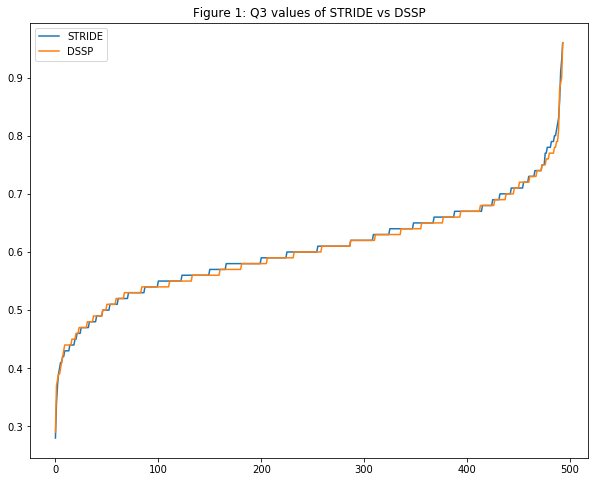

In [12]:
compare_2_values("results/stride_output.csv", "results/dssp_output.csv", 3, "STRIDE", "DSSP", "Figure 1: Q3 values of STRIDE vs DSSP")

## MCC values: STRIDE and DSSP

The Q3 value only tells us how many states are correctly predicted. It does not tell us per state how many of those are correctly predicted. The Mathews Correlation Coefficient tells us per given state, how much % of those states are correctly predicted. We calculated the MCC score for each of the three states and saved them in the output file. 

Figure 2 shows the MCC score for the **Helix** state for the STRIDE and the DSSP datasets. Immediately we notice that the STRIDE data points contain a larger range than the DSSP data points. This means that the predicted Helix states for the STRIDE dataset is slightly more accurate than the Helix state predictions in the DSSP dataset. However, the difference is not huge, except for a few data points.

Figure 3 shows us the MCC score for the **Sheet** state for both the datasets. We notice that the DSSP dataset has more outliers in this graph, they go in both directions, meaning that sometimes the Sheet states are more accurate than the rest, but the opposite is also true. We notice that the overall score lies more often in the same sub range (from 0.2 to 0.6) as compared to Figure 2 were they lie more often in sub range 0.1 to 06. 

Figure 4 shows us the MCC score for the **Coil** states for both the datasets. We have to keep in mind that for every state, that was originally an Other, we have mapped those as Coils. Meaning that we had more Coil information that is actually meant for two states. As the graph progresses to the middle, we notice that there are more data points 0.4 a,d 0.6. A slower upward slope means that more Q3 values are calculated to lie around those values. Again, this can be the result of mapping the Other states to Coil states.

In conclusion, we can say that all three of the MCC states have about the same frequency. They generate almost the same curve, with slight variations. This is a result because the datasets are almost alike, by mapping the Other states to Coil states. Most of the data points hover between 0.4 and 0.6, which is a relative good number. This mean that on average 50% of the state types are correctly predicted. Should we have a larger dataset, with more points and variating data, then this number could be increased by increaing the training of the algorithm. 

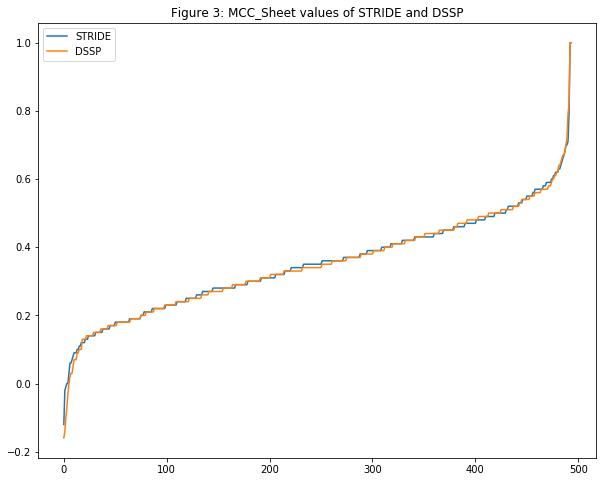

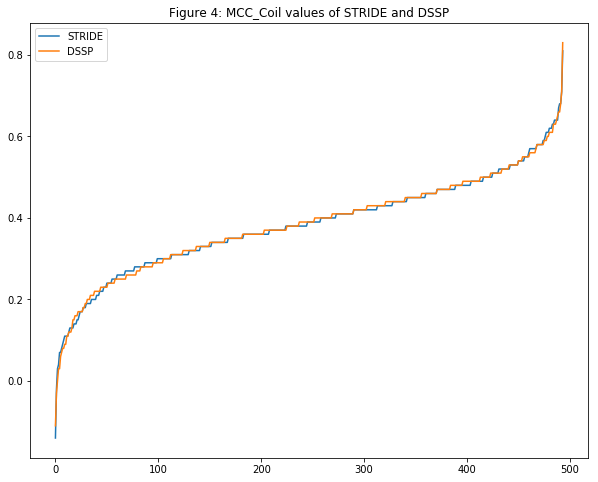

In [13]:
compare_2_values("results/stride_output.csv", "results/dssp_output.csv", 4, "STRIDE", "DSSP", "Figure 2: MCC_Sheet values of STRIDE and DSSP")
compare_2_values("results/stride_output.csv", "results/dssp_output.csv", 5, "STRIDE", "DSSP", "Figure 3: MCC_Sheet values of STRIDE and DSSP")
compare_2_values("results/stride_output.csv", "results/dssp_output.csv", 6, "STRIDE", "DSSP", "Figure 4: MCC_Coil values of STRIDE and DSSP")

## Comparison of Q3 values per protein family

This section compares the overall Q3 average per protein family. By looking at the results in the cell below, we can see that the average per protein family hovers around 60 %. This means that per protein family we have a prediction accuracy of an average of +- 60% per family. The goal was to reach the theoretical 63% of the GOR III algorithm, which is achieved. The None family has the highest prediction accuracy. 

In [32]:
def generate_averages_families(col, label):
    alpha_data = round(np.mean(get_array_csv('results/combined_alpha_output.csv', col)), 2)
    beta_data = round(np.mean(get_array_csv('results/combined_beta_output.csv', col)), 2)
    alphabeta_data = round(np.mean(get_array_csv('results/combined_alphabeta_output.csv', col)), 2)
    none_data = round(np.mean(get_array_csv('results/combined_none_output.csv', col)),2)

    #Display results
    print("The overall " + label + " of the Alpha protein family is: " + str((alpha_data * 100)) + " %.")
    print("The overall " + label + " of the Alpha/Beta protein family is: " + str((alphabeta_data * 100)) + " %.")
    print("The overall " + label + " of the Beta protein family is: " + str((beta_data * 100)) + " %.")
    print("The overall " + label + " of the None protein family is: " + str((none_data * 100)) + " %.")

In [38]:
# Display Q3 for all protein families.
generate_averages_families(3, "Q3 value")

The overall Q3 value of the Alpha protein family is: 63.0 %.
The overall Q3 value of the Alpha/Beta protein family is: 61.0 %.
The overall Q3 value of the Beta protein family is: 60.0 %.
The overall Q3 value of the None protein family is: 64.0 %.


## Comparison of the MCC values per protein family
The MCC value for every state per protein family is calculated. This result is then averaged by the np.mean function to create an average MCC score per state per family. These numbers tell us the accuracy rate of how well a given state has been predicted per protein family. When we look at the results in the next cell, we notice that the first impression is that these numbers hover around the same range. The overal accuracy prediction of a state per protein family hovers around ~35%. Only the Helix value for the Alpha and the None families reach a higher percentage than 40%.

In [39]:
# Display MCC Helix averages for all protein families.
generate_averages_families(4, "MCC Helix value")
print("")
# Display MCC Sheet averages for all protein families.
generate_averages_families(5, "MCC Sheet value")
print("")
# Display MCC Coil averages for all protein families
generate_averages_families(6, "MCC Coil value")

The overall MCC Helix value of the Alpha protein family is: 41.0 %.
The overall MCC Helix value of the Alpha/Beta protein family is: 37.0 %.
The overall MCC Helix value of the Beta protein family is: 38.0 %.
The overall MCC Helix value of the None protein family is: 42.0 %.

The overall MCC Sheet value of the Alpha protein family is: 31.0 %.
The overall MCC Sheet value of the Alpha/Beta protein family is: 35.0 %.
The overall MCC Sheet value of the Beta protein family is: 35.0 %.
The overall MCC Sheet value of the None protein family is: 36.0 %.

The overall MCC Coil value of the Alpha protein family is: 36.0 %.
The overall MCC Coil value of the Alpha/Beta protein family is: 38.0 %.
The overall MCC Coil value of the Beta protein family is: 39.0 %.
The overall MCC Coil value of the None protein family is: 39.0 %.
